In [17]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from keras_bert import load_trained_model_from_checkpoint, Tokenizer

import codecs
import unicodedata
import re
import numpy as np
import os
import io
import time

# import MeCab

In [111]:
print(tf.__version__, tf.keras.__version__)

1.14.0 2.2.4-tf


In [4]:
# jpn-english material
path_to_file = "./jpn-eng/jpn.txt"

In [5]:
# bert model parameters
SEQ_LEN = 64
BATCH_SIZE = 64
OUTPUT_LAYER_NUM = 4
LEARNING_RATE = 1e-5

PRETRAINED_PATH = 'bert-master/Japanese_L-12_H-768_A-12_E-30_BPE/'
CONFIG_PATH = PRETRAINED_PATH + 'bert_config.json'
CHECKPOINT_PATH = PRETRAINED_PATH + 'bert_model.ckpt'
VOCAB_PATH = PRETRAINED_PATH + 'vocab.txt'

In [6]:
# load bert model
bert_model = load_trained_model_from_checkpoint(
  CONFIG_PATH,
  CHECKPOINT_PATH,
  training=False,
  trainable=False,
  output_layer_num=OUTPUT_LAYER_NUM,
  seq_len=SEQ_LEN
)

In [6]:
# prepare token->idx dictionary
def make_token_dict(vocab_path):
  token_dict = {}
  with codecs.open(vocab_path, 'r', 'utf8') as reader:
    for line in reader:
      if line != ' \n':
        token = line.strip()
      else:
        token = line.strip('\n')
      token_dict[token] = len(token_dict)
  return token_dict

W0829 14:12:56.373942 15000 deprecation_wrapper.py:119] From C:\Users\di.sun\AppData\Local\Continuum\anaconda3\envs\tensorflow1\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0829 14:12:56.398949 15000 deprecation_wrapper.py:119] From C:\Users\di.sun\AppData\Local\Continuum\anaconda3\envs\tensorflow1\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0829 14:12:56.499941 15000 deprecation_wrapper.py:119] From C:\Users\di.sun\AppData\Local\Continuum\anaconda3\envs\tensorflow1\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0829 14:12:56.501940 15000 deprecation_wrapper.py:119] From C:\Users\di.sun\AppData\Local\Continuum\anaconda3\envs\tensorflow1\lib\site-packages\keras\backend\tensorflow_backe

In [7]:
def preprocess_eng_sentence(w):
    w = w.lower().strip()

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '[CLS] ' + w + ' [SEP]'
    return w

def preprocess_jpn_sentence(w):
    m = MeCab.Tagger ("-Owakati")
    w = '[CLS] ' + m.parse(w).strip().strip('\n') + ' [SEP]'
    return w

In [13]:
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    eng, jpn = [], []
    for l in lines[:num_examples]:
#         (eng_sentence, jpn_sentence) = l.split('\t')
        (eng_sentence, _) = l.split('\t')
        eng.append(preprocess_eng_sentence(eng_sentence))
#         jpn.append(preprocess_jpn_sentence(jpn_sentence))
    return eng, jpn

In [14]:
eng, jpn = create_dataset(path_to_file, None)

In [ ]:
print(eng[3])
print(jpn[3])

In [9]:
def max_length(tensor):
    return max(len(t) for t in tensor)

def tokenize(lang):
    # convert words(of a sentence) into word indexes
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
                     filters='')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)
    # padding word indexes(of sentences) to the same length(using maximum length of all sentences)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                           padding='post')

    return tensor, lang_tokenizer

# def load_dataset(path, num_examples=None):
#     # creating cleaned input, output pairs
#     targ_lang, inp_lang = create_dataset(path, num_examples)

#     input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
#     target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

#     return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [50]:
def load_dataset(path, input_vocab_path, num_examples=None, verbose=False):
  # creating cleaned input, output pairs
  targ_lang, _ = create_dataset(path, num_examples)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  input_token_dict = make_token_dict(input_vocab_path)
  inp_lang_tokenizer = Tokenizer(input_token_dict, cased=True)
  
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  inp_ids, inp_segments = [], []
  for l in lines[:num_examples]:
      (_, jpn_sentence) = l.split('\t')
      id, segment = inp_lang_tokenizer.encode(jpn_sentence, max_len=SEQ_LEN)
      inp_ids.append(id)
      inp_segments.append(segment)
      if verbose:
        print('{}->{}{}'.format(jpn_sentence, id, segment))
  

  return inp_ids, inp_segments, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [ ]:
inp_ids, inp_segments, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, VOCAB_PATH, 3)

In [60]:
# Try experimenting with the size of that dataset
num_examples = 45000
# input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)
inp_ids, inp_segments, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, VOCAB_PATH, num_examples)
input_tensor = []
for i, s in zip(inp_ids, inp_segments):
  input_tensor.append([i,s])

# Calculate max_length of the target tensors
# max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)
max_length_targ, max_length_inp = max_length(target_tensor), SEQ_LEN

# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

36000 36000 9000 9000


In [68]:
inp_lang.decode([2, 5, 3])

['の']

In [61]:
print(max_length_targ, max_length_inp)

29 64


In [73]:
def convert(lang, tensor):
  if isinstance(lang, tf.keras.preprocessing.text.Tokenizer):
    for t in tensor:
      if t!=0:
        print ("%d ----> %s" % (t, lang.index_word[t]))
  else:
    print (lang.decode(tensor))

print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0][0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

In [74]:
print(len(input_tensor_train))

36000


In [75]:
BUFFER_SIZE = len(input_tensor_train)
# BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 3072 # concatenation of last 4 layer ouputs of Transformer
units = 1024
# vocab_inp_size = len(inp_lang.word_index)+1
vocab_inp_size = len(inp_lang._token_dict)
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [88]:
print(vocab_inp_size, vocab_tar_size)
input_tensor_train = np.array(input_tensor_train)
print(input_tensor_train[:64, 1, :].shape)
print(len(input_tensor_train))

32005 8844
(64, 64)
36000


In [105]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz, bert_model=None):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        if not bert_model:
          self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        else:
          self.embedding = bert_model
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden, bert_model=False):
        if not bert_model:
          x = self.embedding(x)
        else:
          x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [106]:
example_input_batch = input_tensor_train[:2]
print([example_input_batch[:, 0, :], example_input_batch[:, 1, :]])
print(example_input_batch[:, 0, :].shape)

[array([[    2,   149,  1099,     9, 23025,  4330,  1607,  1512,     5,
         3191,    10,   940, 10759,   668,     7,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [    2,  8882,   226,     8,  9013,  1357,   429,  4330,   635,
         1247, 16614,   856,     7,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,    

In [108]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE, bert_model=bert_model)
# sample input
sample_hidden = encoder.initialize_hidden_state()
example_input_batch = input_tensor_train[:64]

sample_output, sample_hidden = encoder([example_input_batch[:, 0, :], example_input_batch[:, 1, :]], sample_hidden, bert_model=True)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

AttributeError: in converted code:

    <ipython-input-105-99ea45c21904>:20 call *
        output, state = self.gru(x, initial_state = hidden)
    C:\Users\di.sun\AppData\Local\Continuum\anaconda3\envs\tensorflow1\lib\site-packages\tensorflow\python\keras\layers\recurrent.py:669 __call__
        return super(RNN, self).__call__(inputs, **kwargs)
    C:\Users\di.sun\AppData\Local\Continuum\anaconda3\envs\tensorflow1\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:663 __call__
        inputs, outputs, args, kwargs)
    C:\Users\di.sun\AppData\Local\Continuum\anaconda3\envs\tensorflow1\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1708 _set_connectivity_metadata_
        input_tensors=inputs, output_tensors=outputs, arguments=kwargs)
    C:\Users\di.sun\AppData\Local\Continuum\anaconda3\envs\tensorflow1\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1795 _add_inbound_node
        input_tensors)
    C:\Users\di.sun\AppData\Local\Continuum\anaconda3\envs\tensorflow1\lib\site-packages\tensorflow\python\util\nest.py:515 map_structure
        structure[0], [func(*x) for x in entries],
    C:\Users\di.sun\AppData\Local\Continuum\anaconda3\envs\tensorflow1\lib\site-packages\tensorflow\python\util\nest.py:515 <listcomp>
        structure[0], [func(*x) for x in entries],
    C:\Users\di.sun\AppData\Local\Continuum\anaconda3\envs\tensorflow1\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1794 <lambda>
        inbound_layers = nest.map_structure(lambda t: t._keras_history.layer,

    AttributeError: 'tuple' object has no attribute 'layer'


In [14]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [15]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 44, 1)


In [16]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [17]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 8844)


In [18]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [19]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt-45k-30epoch")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [20]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [21]:
EPOCHS = 30

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.7420
Epoch 1 Batch 100 Loss 1.4641
Epoch 1 Batch 200 Loss 1.5757
Epoch 1 Batch 300 Loss 1.3221
Epoch 1 Batch 400 Loss 1.3000
Epoch 1 Batch 500 Loss 1.2700
Epoch 1 Loss 1.4130
Time taken for 1 epoch 2605.316736459732 sec

Epoch 2 Batch 0 Loss 1.2374
Epoch 2 Batch 100 Loss 1.1347
Epoch 2 Batch 200 Loss 1.3038
Epoch 2 Batch 300 Loss 1.0643
Epoch 2 Batch 400 Loss 1.0721
Epoch 2 Batch 500 Loss 1.0474
Epoch 2 Loss 1.0984
Time taken for 1 epoch 2553.679552793503 sec

Epoch 3 Batch 0 Loss 1.0400
Epoch 3 Batch 100 Loss 0.9062
Epoch 3 Batch 200 Loss 1.1028
Epoch 3 Batch 300 Loss 0.8526
Epoch 3 Batch 400 Loss 0.8548
Epoch 3 Batch 500 Loss 0.8447
Epoch 3 Loss 0.8941
Time taken for 1 epoch 2550.599761724472 sec

Epoch 4 Batch 0 Loss 0.8187
Epoch 4 Batch 100 Loss 0.6904
Epoch 4 Batch 200 Loss 0.8948
Epoch 4 Batch 300 Loss 0.6628
Epoch 4 Batch 400 Loss 0.6428
Epoch 4 Batch 500 Loss 0.6388
Epoch 4 Loss 0.6873
Time taken for 1 epoch 2556.8588938713074 sec

Epoch 5 Batch 0 Loss 0.

In [35]:
def evaluate(sentence, verbose=False):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    if verbose == True:
        print('Original sentence: {}'.format(sentence))

    sentence = preprocess_jpn_sentence(sentence)
    if verbose == True:
        print('Preprocessed sentence: {}'.format(sentence))

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    if verbose == True:
        print('Word sequences of sentence: {}'.format(inputs))
        
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    if verbose == True:
        print('Paded sequences of sentence: {}'.format(inputs))

    inputs = tf.convert_to_tensor(inputs)
    if verbose == True:
        print('Tensor of sentence: {}'.format(inputs))

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    if verbose == True:
        print('enc_out: {}'.format(enc_out))
        print('enc_hidden: {}'.format(enc_hidden))

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)
    if verbose == True:
        print('dec_input: {}'.format(dec_input))

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)
        if verbose == True:
            print('dec_input: {}'.format(dec_input))

    return result, sentence, attention_plot

In [22]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [39]:
def translate(sentence, verbose=False):
    result, sentence, attention_plot = evaluate(sentence, verbose)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [24]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> 雨 が 嫌い 。 <end>
Predicted translation: i don t like rain . <end> 


C:\Users\Alice\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 38632 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Alice\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 12364 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Alice\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 23244 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Alice\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 12356 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Alice\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 12290 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Alice\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:176: RuntimeWarning: Glyph 38632 missing from c

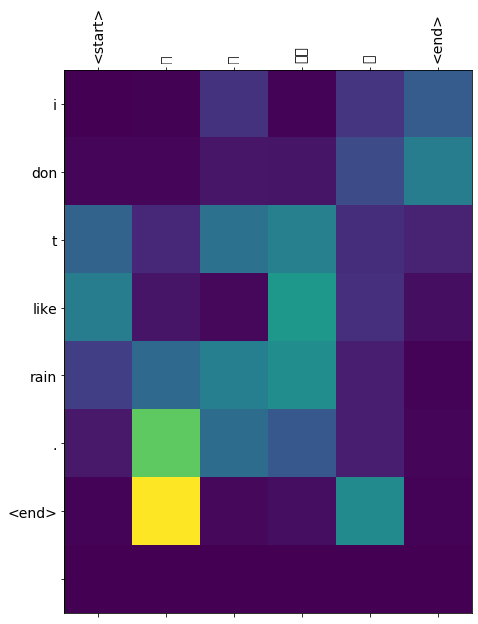

In [25]:
translate(u'雨が嫌い。')

Original sentence: いい天気ですね。
Preprocessed sentence: <start> いい 天気 です ね 。 <end>
Word sequences of sentence: [1, 45, 415, 20, 59, 3, 2]
Paded sequences of sentence: [[  1  45 415  20  59   3   2   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]]
Tensor of sentence: [[  1  45 415  20  59   3   2   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]]
enc_out: [[[ 0.00549655 -0.10430124  0.00152233 ...  0.02123659 -0.03486874
   -0.10197296]
  [ 0.00390758 -0.16195562  0.00699065 ...  0.3110405  -0.04618217
   -0.1307275 ]
  [ 0.03408554 -0.5232086  -0.5766188  ...  0.37764972 -0.9423333
   -0.12432431]
  ...
  [ 0.07000643  0.4793058   0.06101694 ... -0.9345466  -0.92021734
   -0.09653044]
  [ 0.07000935  0.47959706  0.06101688 ... -0.93420655 -0.92021734
   -0.09653616]
  [ 0.07001245  0.479

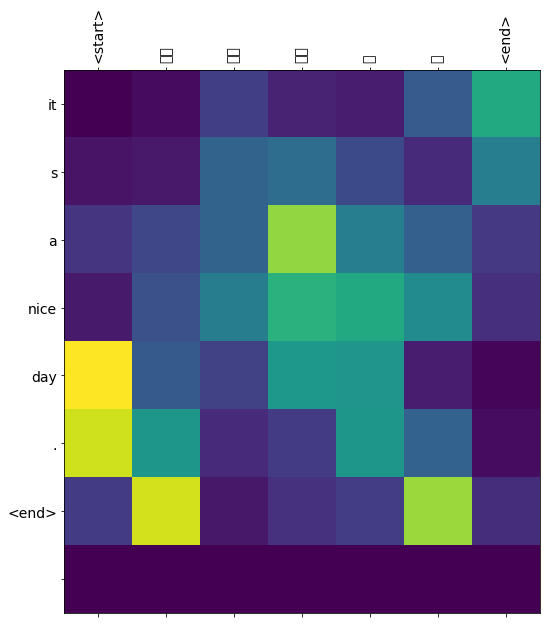

In [42]:
translate('いい天気ですね。', verbose=True)